**Test the BioNER model on N2C2 2018 Track 2 dataset using trained Clinical-BERT. Save to /output**

# Initialize Parameters

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
DATA_VER = "v5"
MODEL_VER = "v7_bdsBERT_v5data"
PARENT_DIR = "/content/gdrive/My Drive/projects/biomedical_ner"
TEST_DIR = PARENT_DIR + "/data/" + DATA_VER + "/test"
MODEL_DIR = PARENT_DIR + "/model/" + MODEL_VER
OUTPUT_DIR = PARENT_DIR + "/output/" + MODEL_VER + "1"

# MODEL_PATH = MODEL_DIR + "/pytorch_model.bin"
VOCAB_PATH = MODEL_DIR + "/vocab.txt"
CONFIG_PATH = MODEL_DIR + "/config.json"
PREDICTIONS_PATH = OUTPUT_DIR + "/predictions.csv"
REPORT_PATH = OUTPUT_DIR + "/result.txt"
CONFUSION_MATRIX_PATH = OUTPUT_DIR + "/confusion_matrix.csv"

In [3]:
import os
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

In [4]:
batch_size = 8
max_len = 384

# Requirements Installation

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install seqeval
!pip install transformers

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=9ccb556d12693fdd35a08c8c35d074731bbdf2f8a6e106a4b4df3e82bdcb3981
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
     |████████████████████████████████| 1.3MB 4.4MB/s 
     |████████████████████████████████| 1.1MB 29.2MB/s 
     |████████████████████████████████| 2.9MB 40.2MB/s 
     |████████████████████████████████| 890kB 53.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c01ddcef0a2251cad68c2e1969c2f88fb8ec94c70f354af22392c5c3dd1962d8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Imports

In [6]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F

import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import DataLoader, SequentialSampler, Dataset, ConcatDataset
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, BertTokenizer, BertForTokenClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [7]:
# Check library version
!pip list | grep -E 'transformers|torch|Keras'

Keras                         2.4.3          
Keras-Preprocessing           1.1.2          
torch                         1.6.0+cu101    
torchsummary                  1.5.1          
torchtext                     0.3.1          
torchvision                   0.7.0+cu101    
transformers                  3.4.0          


# Setup Mapping

In [8]:
tag2idx = {'B-Drug': 0,
          'I-Drug': 1,
          'B-Reason': 2,
          'I-Reason': 3,
          'B-ADE': 4,
          'I-ADE': 5,
          'O': 6,
          'X': 7,
          '[CLS]': 8,
          '[SEP]': 9
          }
tag2name = {tag2idx[key] : key for key in tag2idx.keys()}

# Setup GPU

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

1

# Prepare Data

In [10]:
!ls '$TEST_DIR' | wc -l

202


In [11]:
class ClinicalDataset(Dataset):
    def __init__(self, file, path, max_seq_len, tag2idx, tokenizer):
        self.max_seq_len = max_seq_len;
        self.path = os.path.join(path, file)
        self.df = pd.read_csv(self.path, names=['patientID', 'sentenceID', 'token', 'tag'], keep_default_na=False)
        self.tag2idx = tag2idx
        self.tokenizer = tokenizer
        # Convert Tokens to indices
        self.prepare_data()

    def prepare_data(self):
        sentences, labels = self.get_sentences(self.df)
        tokenized_texts, word_piece_labels = self.tokenize_text(sentences, labels)

        # Make text token into id
        input_ids = pad_sequences([self.tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                                  maxlen=self.max_seq_len, dtype="long", truncating="post", padding="post")

        # Make label into id, pad with "O" meaning others/wrong
        tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in word_piece_labels],
                             maxlen=self.max_seq_len, value=self.tag2idx["X"],
                             padding="post", dtype="long", truncating="post")
        
        y_text.extend(tokenized_texts)

        # For fine tune of predict, with token mask is 1,pad token is 0
        attention_masks = [[int(i > 0) for i in ii] for ii in input_ids]
        
        self.Sentences = torch.tensor(input_ids)
        self.label_data = torch.tensor(tags)
        self.attention_masks = torch.tensor(attention_masks)

    def get_sentences(self, data):
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(), s["tag"].values.tolist())]
        grouped = data.groupby("sentenceID").apply(agg_func)
        tokenstags = [s for s in grouped]
        sentences = [[s[0] for s in sent] for sent in tokenstags]
        labels = [[s[1] for s in sent] for sent in tokenstags]
        return sentences, labels

    def tokenize_text(self, sentences, labels):
        tokenized_texts = []
        word_piece_labels = []
        i_inc = 0
        for word_list, label in (zip(sentences,labels)):
            temp_label = []
            temp_token = []

            # Add [CLS] at the front
            temp_label.append('[CLS]')
            temp_token.append('[CLS]')

            for word,lab in zip(word_list,label):
                token_list = self.tokenizer.tokenize(word)
                for m,token in enumerate(token_list):
                    temp_token.append(token)
                    temp_label.append(lab)

            # Add [SEP] at the end
            temp_token.append('[SEP]')
            temp_label.append('[SEP]')

            tokenized_texts.append(temp_token)
            word_piece_labels.append(temp_label)

        return tokenized_texts, word_piece_labels

    def __len__(self):
        return len(self.Sentences)

    def __getitem__(self, idx):
        return self.Sentences[idx], self.attention_masks[idx], self.label_data[idx]

In [12]:
VOCAB_PATH

'/content/gdrive/My Drive/projects/biomedical_ner/model/v7_bdsBERT_v5data/vocab.txt'

In [13]:
# Tokenizer
tokenizer = BertTokenizer(vocab_file= VOCAB_PATH, do_lower_case=False)

In [14]:
# TEST DATASET
test_datasets = []
y_text = []
for doc in os.listdir(TEST_DIR):
    test_datasets.append(ClinicalDataset(doc, TEST_DIR, max_len, tag2idx, tokenizer))

# concatenate CSV data
test_dataset = ConcatDataset(test_datasets)

test_sampler = SequentialSampler(test_dataset)

test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size,drop_last=True)

# Load Model

In [15]:
!ls '$MODEL_DIR'

config.json  pytorch_model.bin	vocab.txt


In [16]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_DIR, num_labels=len(tag2idx))

In [17]:
model.cuda();

# Test Model(TODO)

In [18]:
model.eval();

In [19]:
y_true = []
y_pred = []
y_confidence = []

probs = []
out = []
print("***** Running evaluation *****")
print("  Num examples = {}".format(len(test_dataset)))
print("  Batch size = {}".format(batch_size))
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 
    
    # Model Confidence
    logits_prob, _ = torch.max(F.softmax(logits, dim=2),dim=2)
    logits_prob = logits_prob.detach().cpu().numpy()

    # print(logits_prob)
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    
    # Get NER true result
    label_ids = label_ids.to('cpu').numpy()
    
    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()
    
    # Compare the valuable predict result
    for i,mask in enumerate(input_mask):
        # Ground truth
        temp_true = []
        # Prediction
        temp_pred = []

        temp_confidence = []
        for j, m in enumerate(mask):
            # Mark=0 (Label_ids = "X"), meaning its a pad word, dont compare
            if m:
                if tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]":
                    temp_true.append(tag2name[label_ids[i][j]])
                    temp_pred.append(tag2name[logits[i][j]])
                    temp_confidence.append(logits_prob[i][j])
                    # TODO: F1 Logic (Lenient)
                    # if tag2name[label_ids[i][j]] == "C" or tag2name[label_ids[i][j]] == "W":
                    #   out.append({"Actual":tag2name[label_ids[i][j]], "Predicted": tag2name[logits[i][j]], "Confidence": logits_prob[i][j]})

            else:
                break
        
            
        y_true.append(temp_true)
        y_pred.append(temp_pred)
        y_confidence.append(temp_confidence)

***** Running evaluation *****
  Num examples = 1765
  Batch size = 8


# Predictions

In [20]:
result = pd.DataFrame()
result["actual"] = y_true
result["predicted"] = y_pred
result["confidence"] = y_confidence

result.to_csv(PREDICTIONS_PATH, sep=",", encoding="utf-8", index=False)

# Analysis

**F1 Scores (Strict & Lenient)**

In [21]:
# Get acc , recall, F1 result report
report_lenient = classification_report(y_true, y_pred, zero_division=1, digits=4)
# report_strict = classification_report(y_true, y_pred, mode='strict', zero_division=1, digits=4)

# Save the report into file
with open(REPORT_PATH, "w") as writer:
    print("***** Eval results(Lenient) *****")
    print("\n%s"%(report_lenient))
    print("F1 score: %f"%(f1_score(y_true, y_pred,zero_division=1)))
    print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
    
    writer.write("F1 score(Lenient):\n")
    writer.write(str(f1_score(y_true, y_pred)))
    writer.write("\n\nAccuracy score:\n")
    writer.write(str(accuracy_score(y_true, y_pred)))
    writer.write("\n\n")  
    writer.write(report_lenient)

    # print("***** Eval results(Strict) *****")
    # print("\n%s"%(report_strict))
    # print("F1 score: %f"%(f1_score(y_true, y_pred,zero_division=1, mode='strict')))
    # print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
    
    # writer.write("F1 score(Strict):\n")
    # writer.write(str(f1_score(y_true, y_pred, mode='strict')))
    # writer.write("\n\nAccuracy score:\n")
    # writer.write(str(accuracy_score(y_true, y_pred)))
    # writer.write("\n\n")  
    # writer.write(report_strict)

***** Eval results(Lenient) *****

              precision    recall  f1-score   support

         ADE     0.1793    0.0370    0.0614      1404
        Drug     0.6736    0.7068    0.6898     30290
      Reason     0.4034    0.1433    0.2115      4864

   micro avg     0.6555    0.6061    0.6299     36558
   macro avg     0.4188    0.2957    0.3209     36558
weighted avg     0.6187    0.6061    0.6020     36558

F1 score: 0.629866
Accuracy score: 0.956319


In [22]:
!ls '$OUTPUT_DIR'

confidence.csv	confusion_matrix.csv  predictions.csv  result.txt


In [23]:
result.head()

,actual,predicted,confidence
0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.999288, 0.99984205, 0.9998673, 0.99996877, ..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.95765775, 0.9981103, 0.99540603, 0.9535741,..."
2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.9999013, 0.99465644, 0.9990809, 0.9999639, ..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.99997497, 0.9999658, 0.9999795, 0.99973184,..."
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.9998455, 0.9999589, 0.99995637, 0.9999815, ..."


**Confusion Matrix**

In [39]:
classes = ['ADE', 'Reason', 'Drug', 'O']

def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label

y_true_total = [get_cleaned_label(item) for sublist in y_true for item in sublist]
y_pred_total = [get_cleaned_label(item) for sublist in y_pred for item in sublist]
y_confidence_total = [item for sublist in y_confidence for item in sublist]
y_text = [[l_i for l_i in l if (l_i != "[CLS]" and l_i != "[SEP]")] for l in y_text]
y_text_total = [item for sublist in y_text for item in sublist][:len(y_pred_total)]


conf_matrix = confusion_matrix(y_true_total, y_pred_total, labels = classes)
conf_df = pd.DataFrame(data=conf_matrix,index=classes,columns=classes)

conf_df.to_csv(CONFUSION_MATRIX_PATH, sep=",", encoding="utf-8")
conf_df

,ADE,Reason,Drug,O
ADE,64,37,182,1736
Reason,31,967,672,6252
Drug,19,108,24086,9198
O,177,675,7955,592522


In [ ]:
y_text_total

In [26]:
!ls '$OUTPUT_DIR'

confidence.csv	confusion_matrix.csv  predictions.csv  result.txt


In [40]:
confidence = pd.DataFrame()
confidence['input'] = y_text_total
confidence['actual'] = y_true_total
confidence['pred'] = y_pred_total

# confidence['correct'] = np.where((confidence['actual'] == confidence['pred']), y_confidence_total , np.NaN)
# confidence['wrong'] = np.where((confidence['actual'] != confidence['pred']), y_confidence_total, np.NaN)
confidence['wrong_actual'] = np.where((confidence['actual'] != confidence['pred']), confidence['actual'], np.NaN)
confidence['wrong_pred'] = np.where((confidence['actual'] != confidence['pred']), confidence['pred'], np.NaN)

# confidence['correctADE'] = np.where((confidence['actual'] == confidence['pred']) & (confidence['actual']=='ADE') , y_confidence_total , np.NaN)
# confidence['wrongADE'] = np.where((confidence['actual'] != confidence['pred']) & (confidence['actual']=='ADE'), y_confidence_total, np.NaN)

# confidence['correctReason'] = np.where((confidence['actual'] == confidence['pred']) & (confidence['actual']=='Reason') , y_confidence_total , np.NaN)
# confidence['wrongReason'] = np.where((confidence['actual'] != confidence['pred']) & (confidence['actual']=='Reason'), y_confidence_total, np.NaN)

# confidence['correctDrug'] = np.where((confidence['actual'] == confidence['pred']) & (confidence['actual']=='Drug') , y_confidence_total , np.NaN)
# confidence['wrongDrug'] = np.where((confidence['actual'] != confidence['pred']) & (confidence['actual']=='Drug'), y_confidence_total, np.NaN)
CONFIDENCE_PATH = OUTPUT_DIR + "/confidence.csv"
# confidence = confidence[confidence['wrong'].notnull()]
confidence.to_csv(CONFIDENCE_PATH)

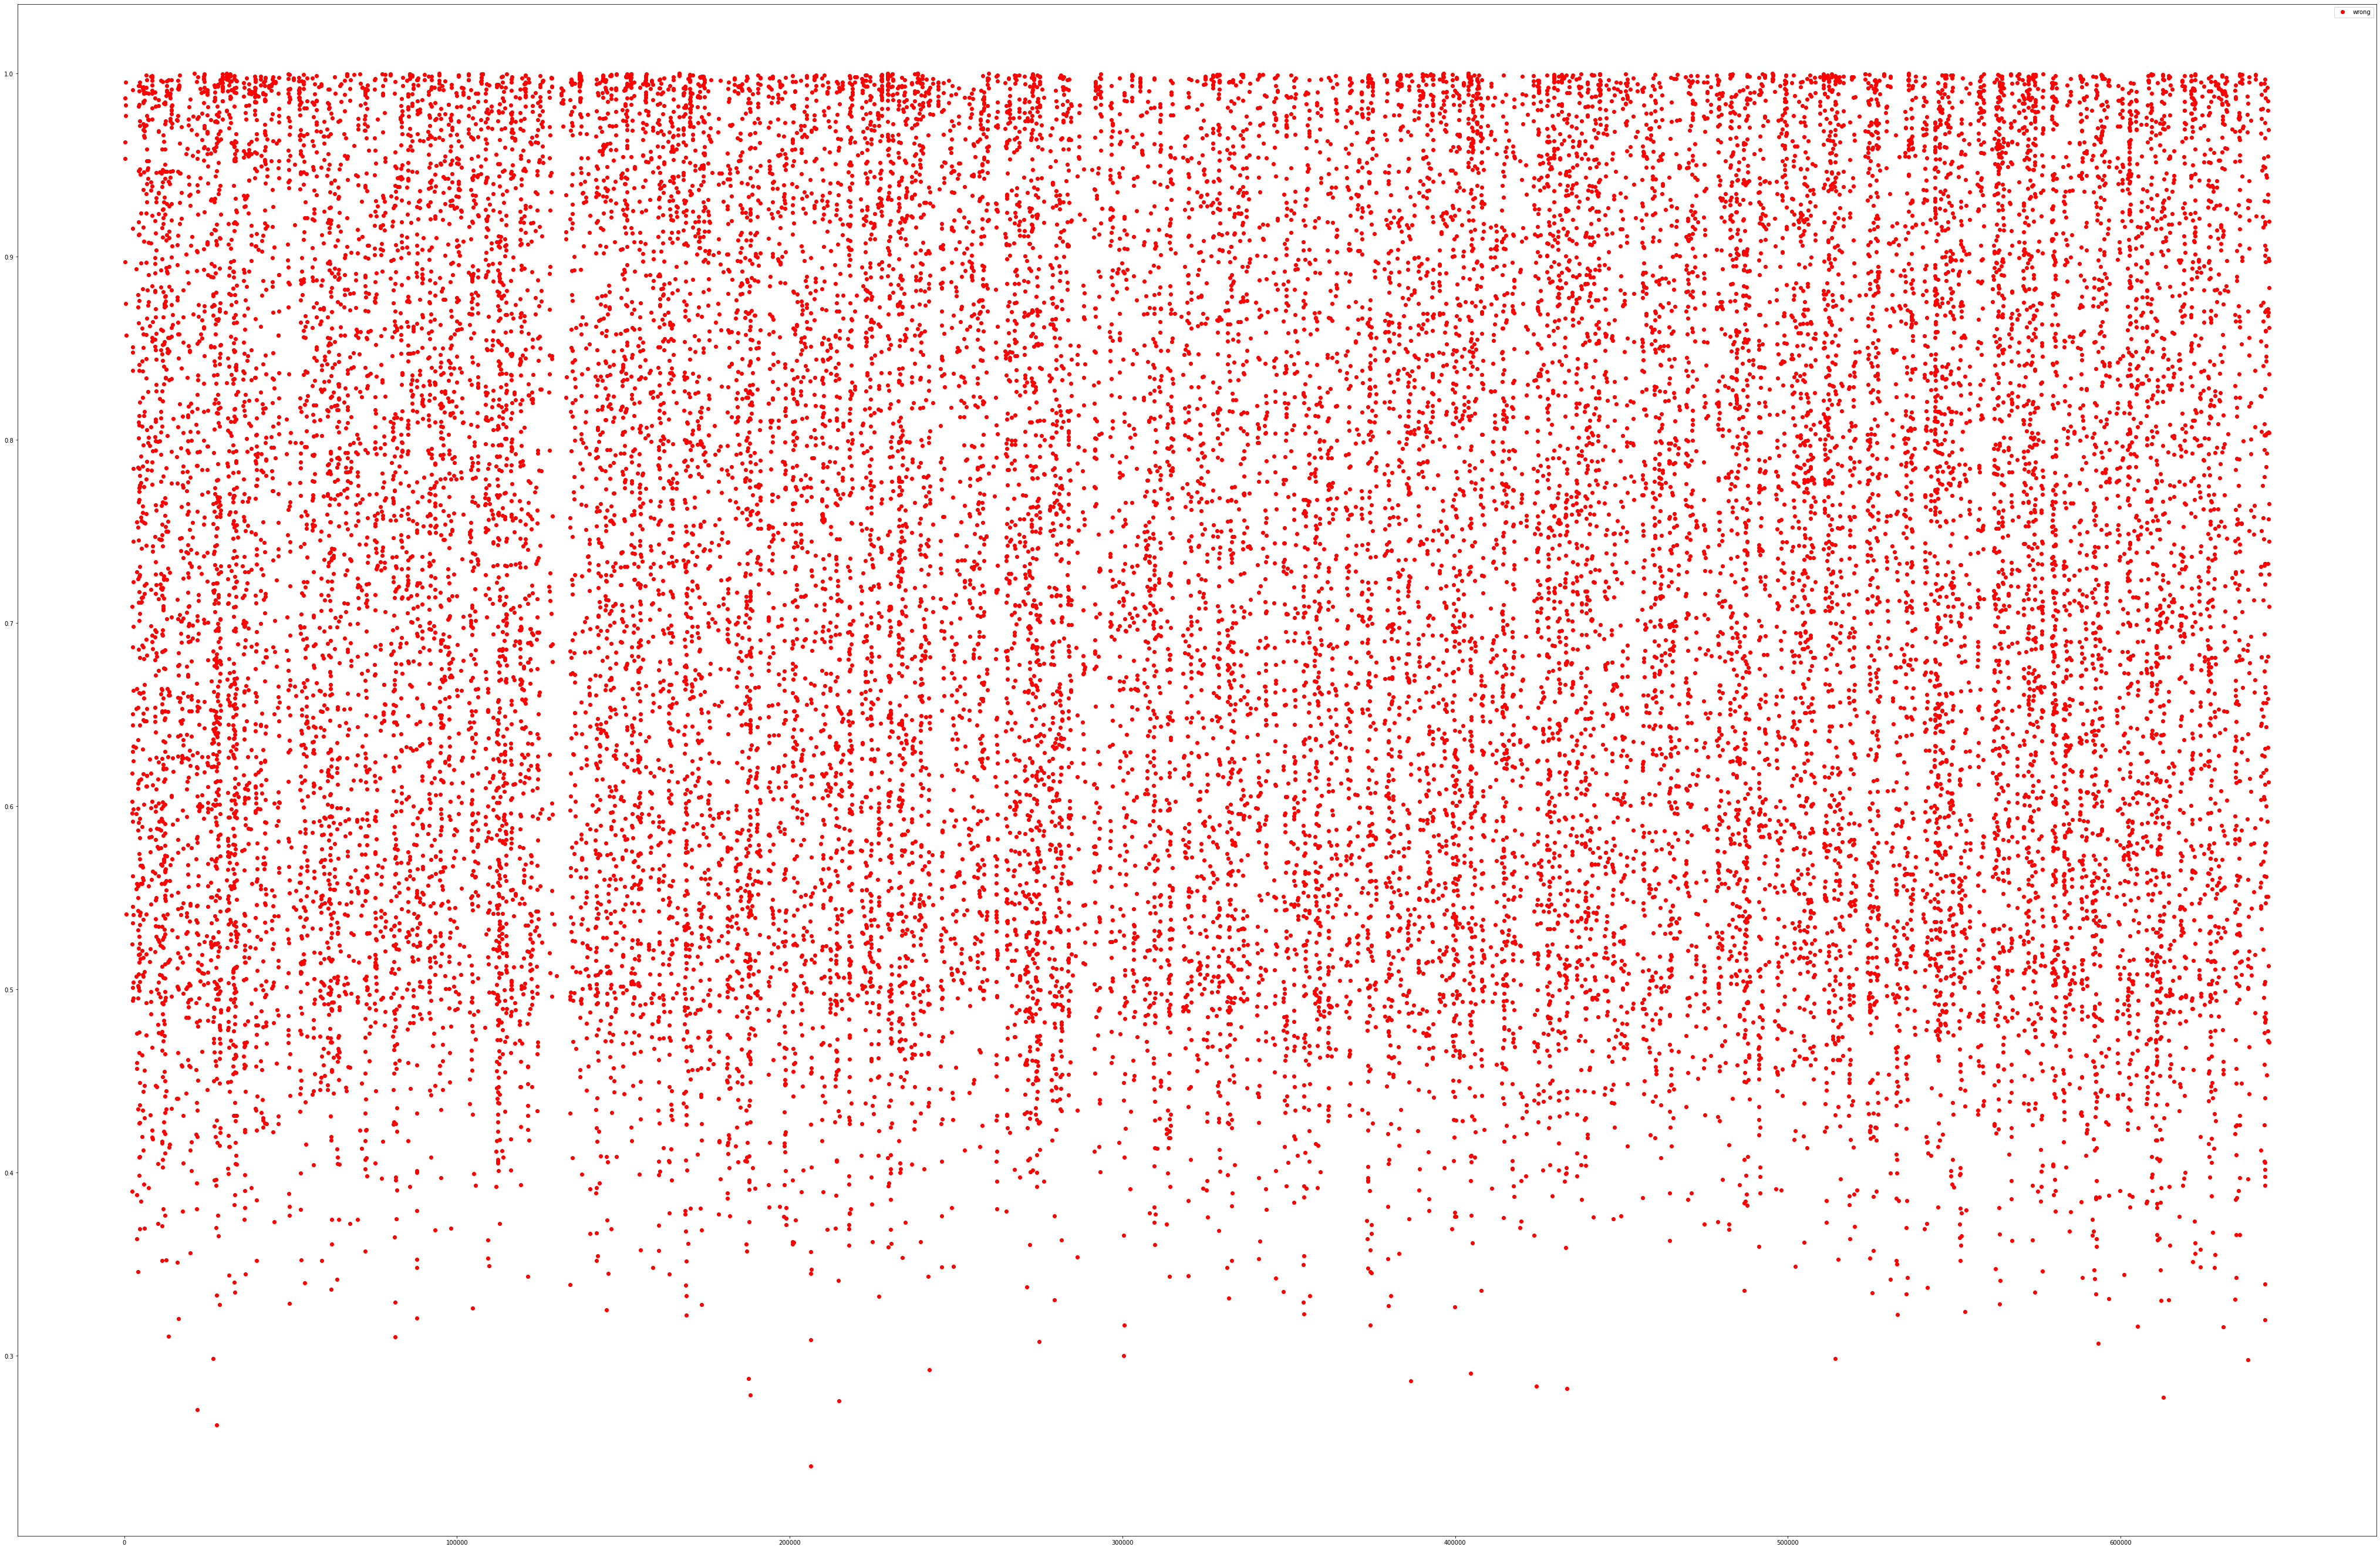

In [28]:
confidence.plot(y=['wrong'], style=['ro'], figsize=(72,48))

In [29]:
confidence.plot(y=['correct'], style=['go'], figsize=(72,48))

Output hidden; open in https://colab.research.google.com to view.

In [30]:
ActualVsPred = pd.DataFrame()
ActualVsPred['actual'] = y_true_total
ActualVsPred['pred'] = y_pred_total

